# Séance 1 - EarlyDropout

On se propose dans ce notebook de reproduire une partie de l'article [Dropout reduces underfitting](https://arxiv.org/abs/2303.01500). Pour le vérifier, nous allons utiliser le dataset Fashion MNIST. Commençons par importer les packages dont nous aurons besoin, importer et standardiser les données.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_valid, y_valid) = (fashion_mnist.load_data())


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28, 1)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28, 1)


label_map = {0: "t-shirt/top", 1: "trouser", 2: "pullover",
             3: "dress", 4: "coat", 5: "sandal",
             6: "shirt", 7: "sneaker", 8: "bag", 9: "ankle boot"}

4422102/4422102 [==============================] - 0s 0us/step


## EarlyDropout

L'early dropout tel que définit dans l'article correspond à avoir la probabilité de dropout strictement supérieure à zéro jusqu'à une certaine époque. Après la valeur vaut 0.

Pour pouvoir reproduire ce fonctionnement, nous allons devoir définir notre propre [callback](https://keras.io/guides/writing_your_own_callbacks/) pour modifier le réseau de neurones pendant l'entraînement.
Nous aurons besoin de :
* La valeur initiale du taux de dropout
* L'époque à laquelle on devra *arrêter* le dropout

Pour avoir l'information de la bonne prise en compte du changement ou non, on se propose d'utiliser un paramètre supplémentaire *verbose* qui aura pour objectif de contrôler l'affichage.


In [2]:
class EarlyDropout(keras.callbacks.Callback):
  def __init__(self, initial_rate, end_epoch, verbose=True):
    self.dropout_rate = initial_rate
    self.initial_value = initial_rate.value()
    self.end_epochs = end_epoch
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs=None):
    value = 0 if ((epoch + 1) >= self.end_epochs) or (self.end_epochs == 0) else self.initial_value
    keras.backend.set_value(self.dropout_rate, value)
    if ((epoch + 1) == self.end_epochs) and self.verbose:
      print("Ending epoch %d, dropout rate is now 0" % (epoch+1))

Nous n'avons besoin d'utiliser que la méthode *on_epoch_end* dans notre utilisation. Nous aurions également pu le faire avec la méthode *on_epoch_begin* à l'époque suivante.


## Réseau de neurones
Définissons à présent le réseau convolutionnel que l'on va exploiter. Pour pouvoir simplement mesurer l'apport (ou non) de l'early dropout, nous allons définir une fonction qui définira, entraînera et renverra les performances de l'entraînement du réseau de neurones.
Nous aurons besoin de définir les paramètres:
* Early dropout : la valeur du dropout et l'époque de fin d'utilisation
* Entraînement : le learning rate et le nombre d'époque

A nouveau, on se propose de contrôler l'affichage de l'entraînement du réseau de neurone avec *verbose* pour alléger les sorties dans ce notebook.

Nous suivons l'article et utilisons un échéancier de learning rate cosinus.

In [3]:
def generate_train_model(dropout_rate, end_epoch, learning_rate=1e-3, n_epochs=10, warmup_epochs=2, decay_epochs=5, batch_size=32, verbose=0):
  dropout_rate_variable = keras.backend.variable(dropout_rate)

  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal", input_shape=X_train.shape[1:]),
    keras.layers.Dropout(rate=dropout_rate_variable),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=dropout_rate_variable),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=dropout_rate_variable),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(64, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
  ])

  callback_verbose = verbose > 0
  callback = EarlyDropout(dropout_rate_variable, end_epoch=end_epoch, verbose=callback_verbose)


  decay_steps = (X_train.shape[0] / batch_size) * decay_epochs
  warmup_steps = (X_train.shape[0] / batch_size) * warmup_epochs
  schedule = keras.optimizers.schedules.CosineDecay(
      initial_learning_rate = learning_rate * 1e-4,
      decay_steps = decay_steps,
      alpha=5e-2,
      warmup_target=learning_rate,
      warmup_steps = warmup_steps
  )

  model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=schedule), metrics=["accuracy"])
  history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[callback], verbose=verbose)
  return pd.DataFrame(history.history)

Nous avons décider d'utiliser l'optimizer Adam avec les valeurs par défaut ici, mais nous aurions pu faire autrement.


## Comparer plusieurs choix

Pour simplifier l'écriture de multiple test, et simplifier le stockage des historiques d'apprentissage, on se propose d'utiliser une fonction pour le faire.
Elle nécessite une liste d'expériences à réaliser. Chaque expérience est un dictionnaire que l'on paramètre avec:
* **type** : le nom de l'expérience
* **function** : la fonction qui génére l'historique d'apprentissage
* **parameters** : les paramètres à renseigner pour appeler la fonction *function*

Cette fonction réalisera l'ensemble des expériences un certain nombre de fois pour pouvoir potentiellement estimer un interval de confiance.

In [5]:
def compare_architectures(comparisons, comparisons_number=2):
  results = []


  for index in range(comparisons_number):
    print("Comparison %d :" % (index+1), end=" ")

    for element in comparisons:
      print("%s..." % element["type"], end= " ")
      function, parameters = element["function"], element["parameters"]
      history = function(**parameters)
      result = {"type": element["type"], "history": history}
      results.append(result)

    print()


  return results

Il ne nous reste plus qu'à générer le dictionnaire d'expériences ! Nous entraînerons sur 100 époques uniquement les réseaux de neurones. Nous considérons ici uniquement trois expériences:
* Un réseau sans dropout
* Un réseau avec un EarlyDropout au bout de 50 époques
* Un réseau avec un dropout constant tout au long de l'entraînement

Comme dans l'article, nous réalisons une période de warmup du learning rate égal à la phase d'early dropout.

In [6]:
dropout_rate = 0.25
learning_rate = 1e-3
n_epochs = 100
warmup_epochs=50
decay_epochs=50
batch_size=1024
epochs = [0, 50, 100]


comparisons = []

for epoch in epochs:
  parameters = {"dropout_rate": dropout_rate,
                "end_epoch": epoch,
                "n_epochs": n_epochs,
                "warmup_epochs": warmup_epochs,
                "decay_epochs": decay_epochs,
                "learning_rate": learning_rate,
                "batch_size": batch_size}

  if epoch == 0:
    name = "No Dropout"
  elif epoch >= n_epochs:
    name = "Dropout"
  else:
    name = "EarlyDropout %d epochs" % epoch

  comparison = {"type": name,
                "function": generate_train_model,
                "parameters": parameters}

  comparisons.append(comparison)

In [7]:
results = compare_architectures(comparisons, comparisons_number=3)

Comparison 1 : No Dropout... EarlyDropout 50 epochs... Dropout... 
Comparison 2 : No Dropout... EarlyDropout 50 epochs... Dropout... 
Comparison 3 : No Dropout... EarlyDropout 50 epochs... Dropout... 


Nous venons de générer un objet *results* qui contient les types et les historiques des différentes expériences réalisées. Nous souhaitons les visualiser de manière simple.

## Visualisation

On se propose de construire une fonction qui exploite spécifiquement cette architecture d'objet pour le faire. Nous générerons deux figures:
1. La valeur de la fonction de perte en fonction du temps d'entraînement
2. La valeur de l'accuracy en fonction du temps d'entraînement

Dans ces deux graphiques, nous présenterons en trait pleins la valeur de l'entraînement et en trait pointillés la valeur de la validation. Nous présenterons chaque type d'expérience sur chaque graphique accompagné de l'intervalle de confiance pour l'entraînement comme pour la validation.

In [8]:
def plot_comparison(results,  title, confidence=3, figsize=(15, 6), alpha=0.1):

    def agregate_result(key, metric_name):
        training = np.zeros((comparisons_number, n_epochs))
        validation = np.zeros((comparisons_number, n_epochs))
        index = 0
        for result in results:
            if result["type"] == key:
                historic = result["history"]
                training[index] = historic[metric_name]
                validation[index] = historic["val_%s" % metric_name]
                index += 1
        return training, validation


    def get_vector_mean_std(vector):
        mean = vector.mean(axis=0)
        std = vector.std(axis=0)
        return mean, std



    n_epochs = results[0]["history"].shape[0]
    epochs = range(1, n_epochs+1)
    comparisons_number = sum([result["type"] == results[0]["type"] for result in results])
    figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=figsize)
    keys = list(set([result["type"] for result in results]))


    for metric_name, axis in zip(["loss", "accuracy"], [axis_1, axis_2]):

        for index, key in enumerate(keys):
            color = sns.color_palette()[index]
            training, validation = agregate_result(key, metric_name)

            training_mean, training_std = get_vector_mean_std(training)
            axis.plot(epochs, training_mean, lw=2, label=key, color=color)
            axis.fill_between(epochs, training_mean-confidence*training_std, training_mean+confidence*training_std, color=color, alpha=alpha)

            validation_mean, validation_std = get_vector_mean_std(validation)
            axis.plot(epochs, validation_mean, ls="--", color=color)
            axis.fill_between(epochs, validation_mean-confidence*validation_std, validation_mean+confidence*validation_std, color=color, alpha=alpha)

        axis.set_ylabel(metric_name.capitalize())
        axis.set_xlabel("Epochs")
        axis.set_title("%s through training" % metric_name.capitalize())
        axis.legend()


    plt.suptitle(title)
    plt.show()

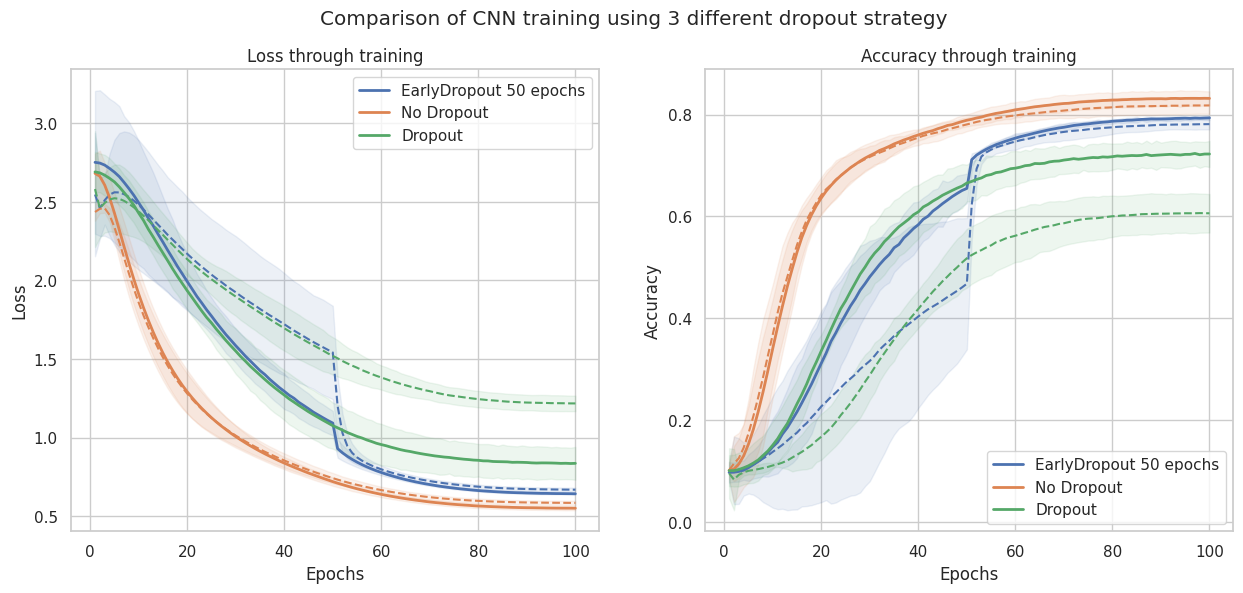

In [9]:
plot_comparison(results,  "Comparison of CNN training using 3 different dropout strategy")

Commençons par noter le décrochage net des deux courbes, mais surtout celle de validation, quand l'EarlyDropout est terminé. Avant ce seuil, les fonctionnements sont très similaire ce qui est cohérent.

On a bien que l'early dropping a permit d'éviter le sous-apprentissage par rapport à la stratégie de dropout complet, également le sur-apprentissage !
Par ailleurs, la stratégie sans dropout est plus performante que les deux précédentes. Probablement parce que l'utilisation de la BatchNormalization permet de régulariser suffisamment le problème dans notre cas.

Il est à noter que nous avons seulement reproduis les résultats du papier uniquement pour ce réseau, et qu'il reste encore des questions :
1. Que se passe-t-il si on arrête le dropout avant/après la fin de la période de warmup ?
2. Que se passe-t-il si on n'utilise pas de période de warmup ?
3. Doit-on avoir une autre régularisation (ici BatchNormalization) ou peut-on s'en passer ?

Et il faut bien sur réaliser ces expérimentations sur plus de datasets différents et plus d'architecture.